In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

sns.set(style="whitegrid")

df = pd.read_csv("src/data/df_precios.csv")










**Las diferencias de precio entre los alojamientos turísticos en Madrid pueden explicarse principalmente por la ubicación, el tipo de alojamiento, las características del anuncio y la época del año.**

In [2]:
precio_mediano = (
    df.groupby("neighbourhood_group")["price"]
    .median()
    .sort_values(ascending=False))

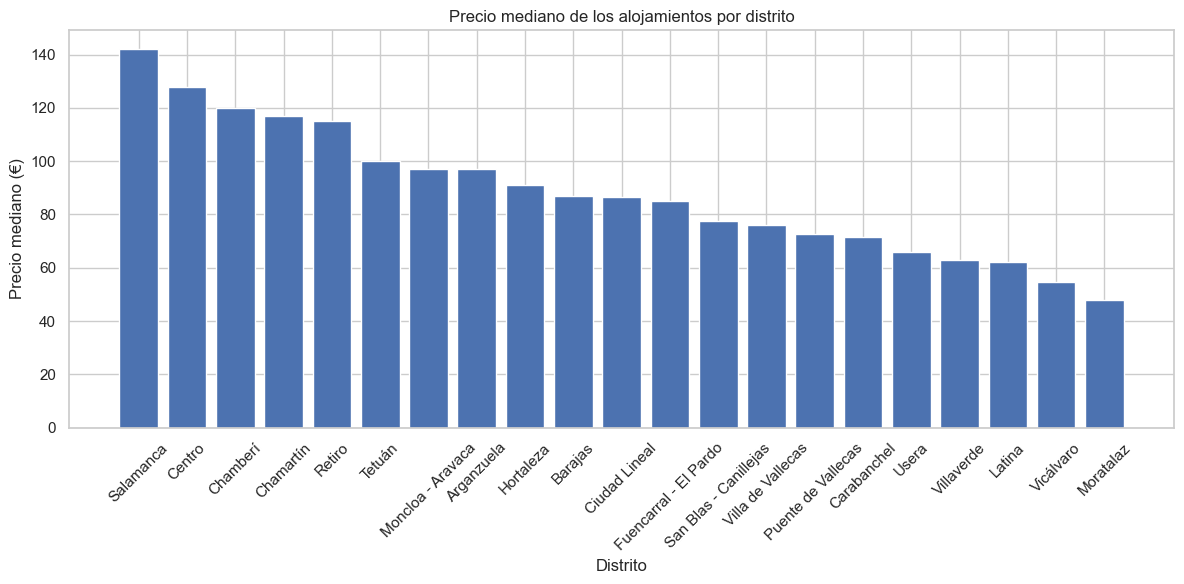

In [3]:
# lo primero es ver si realmente hay una relación entre la variable ubicación y la variable precio
plt.figure(figsize=(12,6))
plt.bar(precio_mediano.index, precio_mediano.values)
plt.title("Precio mediano de los alojamientos por distrito")
plt.xlabel("Distrito")
plt.ylabel("Precio mediano (€)")
plt.xticks(rotation=45)
plt.tight_layout()


C:\Users\javie\AppData\Local\Temp\ipykernel_16428\3521813603.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


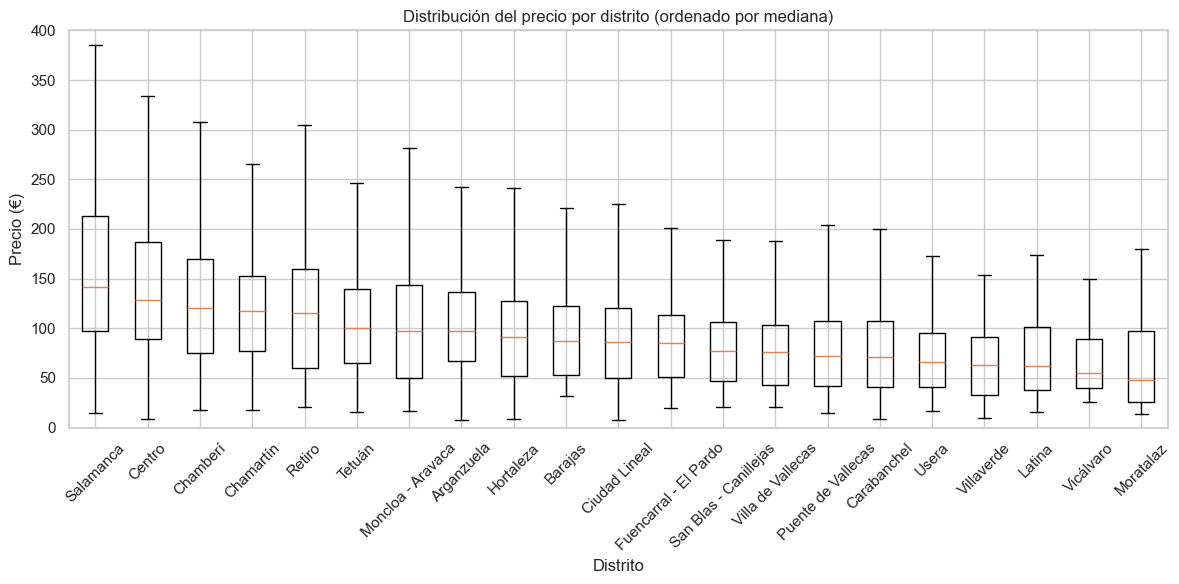

In [4]:
# Ordenar distritos por precio mediano
order = (
    df.groupby("neighbourhood_group")["price"]
    .median()
    .sort_values(ascending=False)
    .index
)
# Crear boxplot claro
plt.figure(figsize=(12,6))
plt.boxplot(
    [df[df["neighbourhood_group"] == d]["price"] for d in order],
    labels=order,
    showfliers=False
)
plt.ylim(0, 400)
plt.title("Distribución del precio por distrito (ordenado por mediana)")
plt.xlabel("Distrito")
plt.ylabel("Precio (€)")
plt.xticks(rotation=45)
plt.tight_layout()


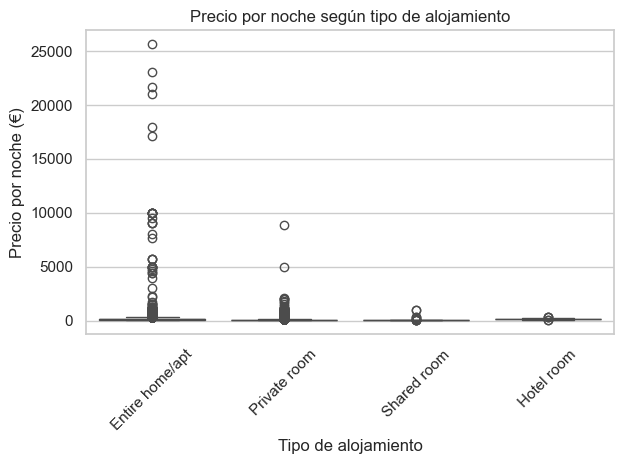

In [5]:
# lo siguiente es ver si hay diferencias en base al tipo de alojamiento

if "room_type" in df.columns:
    fig, ax = plt.subplots()
    sns.boxplot(data=df, x="room_type", y="price", ax=ax)
    ax.set_title("Precio por noche según tipo de alojamiento")
    ax.set_xlabel("Tipo de alojamiento")
    ax.set_ylabel("Precio por noche (€)")
    plt.xticks(rotation=45)

    fig.tight_layout()
    fig.savefig("src/img/boxplot_tipo.png", dpi=300)
    plt.show()

    # Resumen por tipo de alojamiento
    resumen_tipo = df.groupby("room_type")["price"].agg(["count", "mean", "median"]).sort_values("mean", ascending=False)
    resumen_tipo

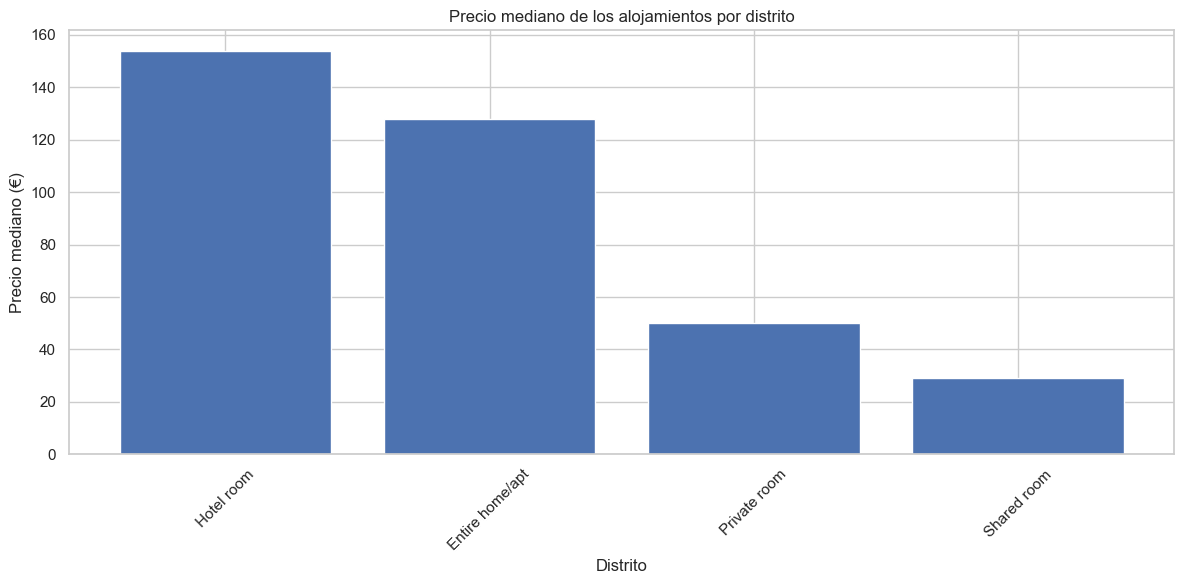

In [6]:
precio_mediano2 = (
    df.groupby("room_type")["price"]
    .median()
    .sort_values(ascending=False))

plt.figure(figsize=(12,6))
plt.bar(precio_mediano2.index, precio_mediano2.values)
plt.title("Precio mediano de los alojamientos por distrito")
plt.xlabel("Distrito")
plt.ylabel("Precio mediano (€)")
plt.xticks(rotation=45)
plt.tight_layout()

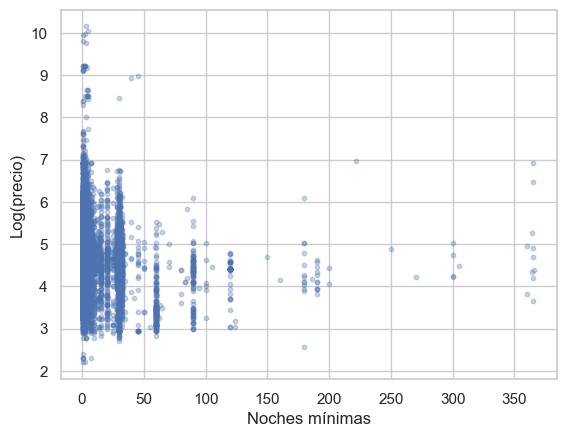

In [7]:
# ahora toca comprobar si el precio varía en base a las características del anuncio (noches mínimas, número de reviews y disponibilidad al año)
df["log_price"] = np.log1p(df["price"])
plt.scatter(
    df["minimum_nights"],
    df["log_price"],
    alpha=0.3,
    s=10
)
plt.xlabel("Noches mínimas")
plt.ylabel("Log(precio)")
plt.show()


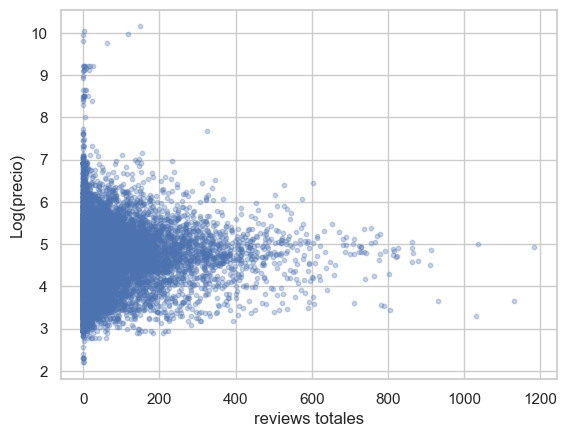

In [8]:
plt.scatter(
    df["number_of_reviews"],
    df["log_price"],
    alpha=0.3,
    s=10
)
plt.xlabel("reviews totales")
plt.ylabel("Log(precio)")
plt.show()


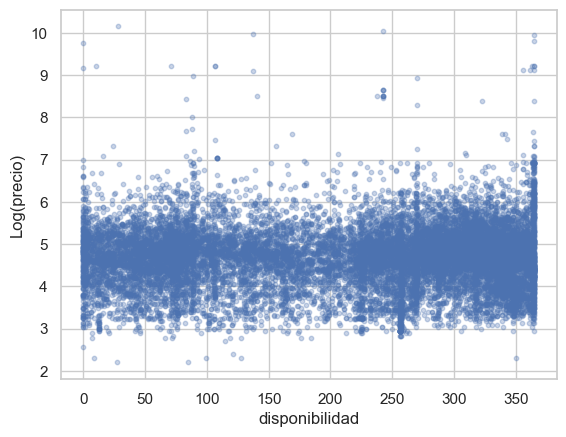

In [9]:
plt.scatter(
    df["availability_365"],
    df["log_price"],
    alpha=0.3,
    s=10
)
plt.xlabel("disponibilidad")
plt.ylabel("Log(precio)")
plt.show()

In [10]:
df[[
    "price",
    "minimum_nights",
    "number_of_reviews",
    "availability_365"
]].corr(method="spearman")


,price,minimum_nights,number_of_reviews,availability_365
price,1.000000,-0.156260,0.076023,0.033426
minimum_nights,-0.156260,1.000000,-0.140099,-0.101158
number_of_reviews,0.076023,-0.140099,1.000000,-0.254846
availability_365,0.033426,-0.101158,-0.254846,1.000000


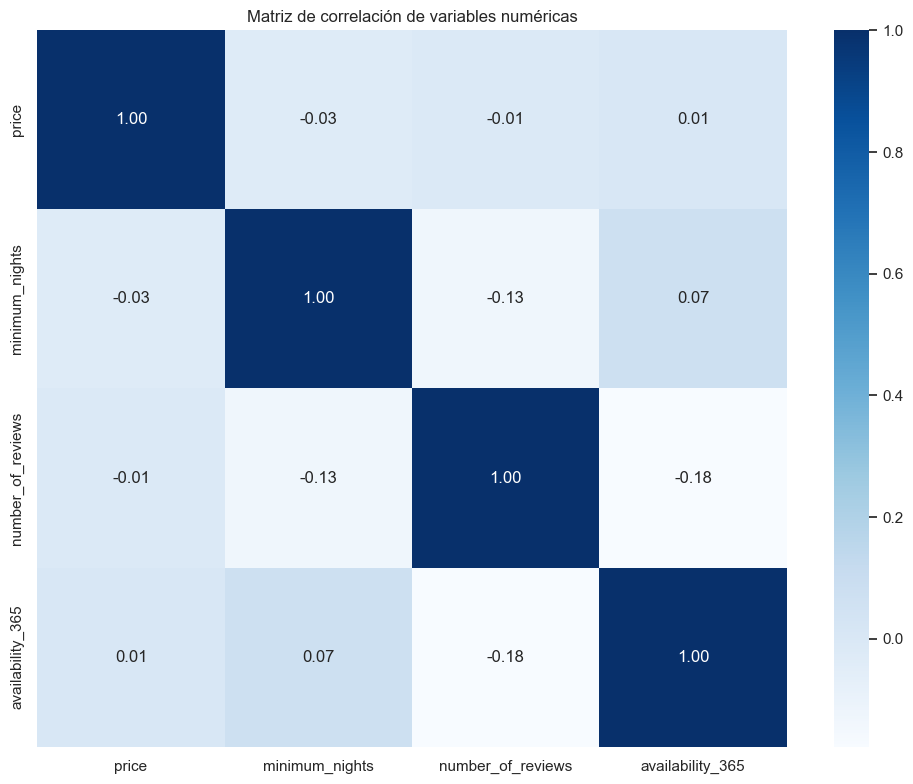

In [11]:
df_corr = df[[
    "price",
    "minimum_nights",
    "number_of_reviews",
    "availability_365"
]]

corr = df_corr.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", ax=ax)
ax.set_title("Matriz de correlación de variables numéricas")

fig.tight_layout()

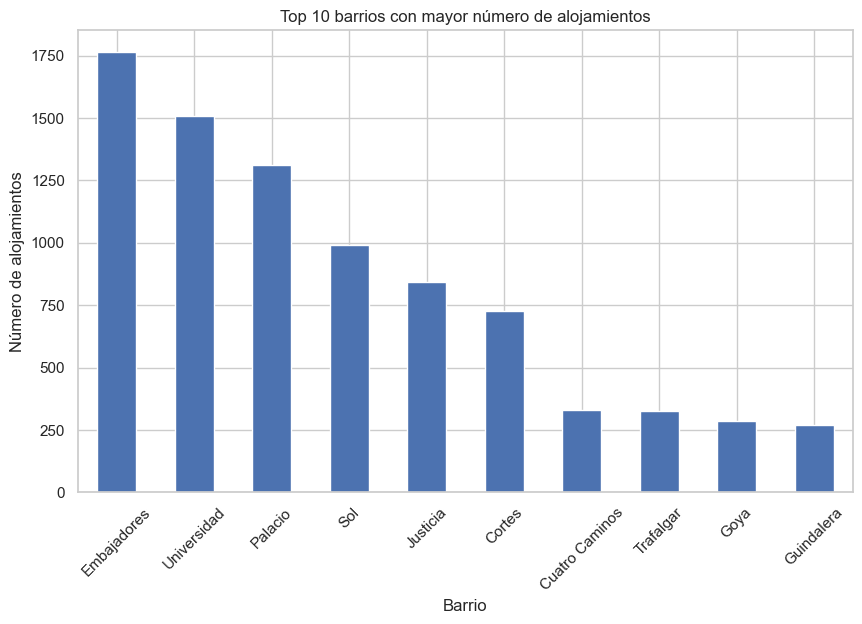

In [12]:
'''1️⃣ ¿Qué barrios concentran más oferta de alojamiento?
Bar chart – Top 10 barrios con más alojamientos'''
top_barrios = (
    df["neighbourhood"]
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,6))
top_barrios.plot(kind="bar")
plt.title("Top 10 barrios con mayor número de alojamientos")
plt.xlabel("Barrio")
plt.ylabel("Número de alojamientos")
plt.xticks(rotation=45)
plt.show()

In [13]:
'''Mapa de densidad (scatter)'''
# mapa interactivo en imágenes

'Mapa de densidad (scatter)'

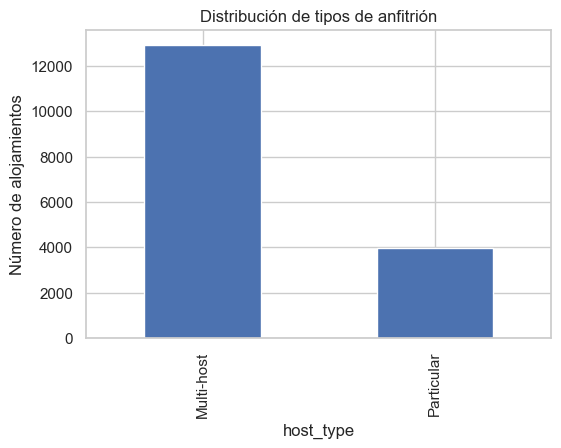

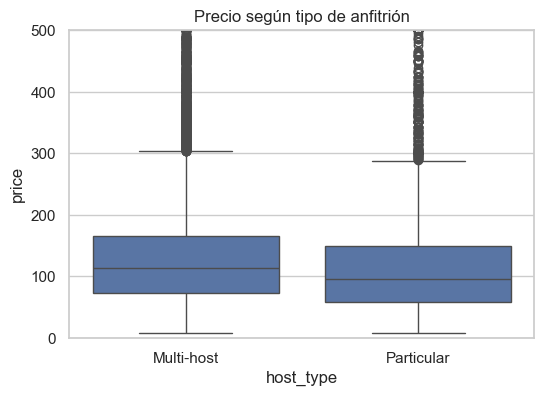

In [14]:
'''3️⃣ ¿Diferencias entre anfitriones particulares y multi-hosts?
Crear variable tipo de anfitrión'''
df["host_type"] = np.where(
    df["calculated_host_listings_count"] > 1,
    "Multi-host",
    "Particular"
)

'''Distribución de anfitriones'''
plt.figure(figsize=(6,4))
df["host_type"].value_counts().plot(kind="bar")
plt.title("Distribución de tipos de anfitrión")
plt.ylabel("Número de alojamientos")
plt.show()

'''Boxplot de precio'''
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x="host_type",
    y="price"
)
plt.ylim(0, 500)
plt.title("Precio según tipo de anfitrión")
plt.show()

In [23]:
# voy a crear una variable que refleje las diferencias entre oferta y demanda, asumiremos que en cierto grado, los pisos con más reviews
# son los pisos con más visitas, pese a que sabemos que no es exacto, es la mejor aproximación que podemos hacer 
reviews_por_barrio = (df.groupby("neighbourhood_group")["number_of_reviews_ltm"].sum().rename("total_reviews"))
pisos_por_barrio = (df.groupby("neighbourhood_group").size().rename("total_pisos"))
df_final= pd.concat([reviews_por_barrio,pisos_por_barrio], axis=1)

In [24]:
df_final

,total_reviews,total_pisos
neighbourhood_group,,
Arganzuela,17544.0,789
Barajas,4688.0,85
Carabanchel,8956.0,612
Centro,146305.0,7145
Chamartín,7069.0,604
Chamberí,12056.0,1078
Ciudad Lineal,10305.0,568
Fuencarral - El Pardo,2263.0,209
Hortaleza,5010.0,359


In [25]:
df_final["proporción_review_apartamento"]=df_final["total_reviews"]/df_final["total_pisos"]

In [27]:
df_final.describe()

,total_reviews,total_pisos,proporción_review_apartamento
count,21.000000,21.000000,21.000000
mean,13833.380952,806.238095,16.573929
std,30747.423906,1492.971899,9.447747
min,788.000000,58.000000,9.636943
25%,4688.000000,209.000000,11.703642
50%,5908.000000,465.000000,14.448753
75%,10305.000000,664.000000,17.479290
max,146305.000000,7145.000000,55.152941


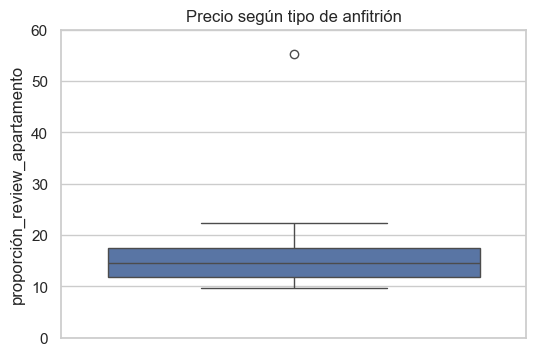

In [31]:
'''Boxplot de precio'''
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df_final,
    y="proporción_review_apartamento"
)
plt.ylim(0,60)
plt.title("Precio según tipo de anfitrión")
plt.show()

In [34]:
df_final["agrupación"] = "Adecuada"

df_final.loc[df_final["proporción_review_apartamento"] > 17.4792899408284,"agrupación"] = "Infravalorada"

df_final.loc[df_final["proporción_review_apartamento"] < 11.70364238410596,"agrupación"] = "Sobrevalorada"


In [36]:
df_final.loc[df_final["agrupación"]=="Infravalorada"]

,total_reviews,total_pisos,proporción_review_apartamento,agrupación
neighbourhood_group,,,,
Arganzuela,17544.0,789,22.235741,Infravalorada
Barajas,4688.0,85,55.152941,Infravalorada
Centro,146305.0,7145,20.476557,Infravalorada
Ciudad Lineal,10305.0,568,18.142606,Infravalorada
Villa de Vallecas,1327.0,69,19.231884,Infravalorada


In [37]:
df_final.loc[df_final["agrupación"]=="Sobrevalorada"]

,total_reviews,total_pisos,proporción_review_apartamento,agrupación
neighbourhood_group,,,,
Chamberí,12056.0,1078,11.183673,Sobrevalorada
Fuencarral - El Pardo,2263.0,209,10.827751,Sobrevalorada
Moncloa - Aravaca,5423.0,465,11.662366,Sobrevalorada
Moratalaz,1249.0,107,11.672897,Sobrevalorada
Villaverde,1513.0,157,9.636943,Sobrevalorada
